### Load Config

In [1]:
from yaml import load, Loader
from bunch import Bunch
Bunch.__str__ = Bunch.__repr__

stream = open("config.yaml", 'r')
config = Bunch(load(stream, Loader=Loader))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

metrics = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

can_data = pd.read_parquet('out/can_data.parquet', columns=['subject_id'])
subject_ids = np.unique(can_data['subject_id'])
yticks = [round(n, 2) for n in np.arange(0.1, 1.1, step=0.1)]

### Visualize Results

##### Window sizes

In [ ]:
# compare window sizes
scores = []
for window_size in config.window_sizes:
    results = pd.read_csv('out/results/{}_{}_pred_results_windowsize_{}.csv'.format(
                config.classifier_type, config.clf_mode, window_size), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    score = results.loc[subject_ids, metrics]
    scores.append(score)
scores = np.array(scores)
for i in range(scores.shape[2]):
    fig, axes = putil.create_plot(nrows=1, ncols=1, sharey=True)
    for ax in axes:
        putil.set_ax_visible_spines(ax, top=False, right=False)
    putil.set_figure_size(fig, 5, 5)
    axes[0].boxplot(np.transpose(scores[:, :, i]))
    putil.set_ax_xticks(axes[0], range(1, scores.shape[0]+1), config.window_sizes)
    putil.set_ax_yticks(axes[0], yticks, yticks)
    putil.set_ax_axis_labels(axes[0], x_label='window sizes [s]', y_label=[s.replace('_', ' ').replace('roc auc', 'AUROC') for s in metrics][i])
    putil.set_ax_bg_color(axes[0], 'whitesmoke')
    putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
    plt.tight_layout()
    plt.savefig('out/results/{}_{}_scores_varying_window_sizes_{}.pdf'.format(config.classifier_type, config.clf_mode, metrics[i]))

In [ ]:
# compare signal combos
mean_scores = []
stddevs = []
window_size = 60
for combo in SIGNAL_COMBOS:
    signal_string = ''
    for signal in combo:
        signal_string += '_' + signal
    results = pd.read_csv('out/results/{}_{}_pred_results_windowsize_{}{}.csv'.format(
                config.classifier_type, config.clf_mode, window_size, signal_string), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    mean_score = results.loc[subject_ids, scores]
    stddev = results.loc['stddev', scores]
    mean_scores.append(mean_score)
    stddevs.append(stddev)
mean_scores = np.array(mean_scores)
stddevs = np.array(stddevs)
for i in range(mean_scores.shape[1]):
    axes[1].plot(range(len(mean_scores)), mean_scores[:, i], markerfacecolor='white', marker="o", label=scores[i])
    axes[1].fill_between(range(len(mean_scores)), y1=mean_scores[:, i]-stddevs[:, i], y2=mean_scores[:, i]+stddevs[:, i], alpha=0.2)
putil.set_ax_xticks(axes[1], range(len(mean_scores)), SIGNAL_COMBOS, rotation=90)
putil.set_ax_axis_labels(axes[1], 'signal combos')
putil.set_ax_bg_color(axes[1], 'whitesmoke')
putil.set_ax_grid_lines(axes[1], True, axis="y", color="w")

##### Step sizes

In [ ]:
# compare step sizes
scores = []
window_size = 120
for step_size in config.step_sizes:
    step = 1
    if step_size is not None:
        results = pd.read_csv('out/results/{}_{}_pred_results_step_size_{}_windowsize_{}.csv'.format(
                    config.classifier_type, config.clf_mode, step_size, window_size), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
        score = results.loc[subject_ids, metrics]
        scores.append(score)
scores = np.array(scores)
for i in range(scores.shape[2]):
    fig, axes = putil.create_plot(nrows=1, ncols=1, sharey=True)
    for ax in axes:
        putil.set_ax_visible_spines(ax, top=False, right=False)
    putil.set_figure_size(fig, 5, 5)
    axes[0].boxplot(np.transpose(scores[:, :, i]))
    putil.set_ax_xticks(axes[0], range(1, scores.shape[0]+1), config.step_sizes)
    putil.set_ax_yticks(axes[0], yticks, yticks)
    putil.set_ax_axis_labels(axes[0], x_label='step sizes [s]', y_label=[s.replace('_', ' ').replace('roc auc', 'AUROC') for s in metrics][i])
    putil.set_ax_bg_color(axes[0], 'whitesmoke')
    putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
    plt.tight_layout()
    plt.savefig('out/results/{}_{}_scores_varying_step_sizes_{}.pdf'.format(config.classifier_type, config.clf_mode, metrics[i]))

### Sliding windows

##### Overall Baseline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

colors = ['blue', 'royalblue', 'green', 'limegreen']

# compare scenarios
for i, window_size in enumerate(config.window_sizes):
    scores = []
    for j, combo in enumerate(SIGNAL_COMBOS):
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal
        results = pd.read_csv('out/results/{}_{}_pred_results_windowsize_{}{}_no_sfs.csv'.format(
                        config.classifier_type, config.clf_mode, window_size, signal_string), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
        scores.append(results.loc[subject_ids, metrics])
    scores = np.array(scores)
    for l in range(scores.shape[2]):
        fig, axes = putil.create_plot()
        putil.set_ax_visible_spines(axes[0], top=False, right=False)
        putil.set_figure_size(fig, 8, 5)
        axes[0].boxplot(np.transpose(scores[:, :, l]))
        putil.set_ax_xticks(axes[0], range(1, len(SIGNAL_COMBOS)+1), [' +\n'.join(combo).replace('_', ' ').replace(' behavior', '') for combo in SIGNAL_COMBOS])
        putil.set_ax_yticks(axes[0], yticks, yticks)
        putil.set_ax_axis_labels(axes[0], x_label='signal combinations', y_label=metrics[l].replace('_', ' ').replace('roc auc', 'AUROC'))
        putil.set_ax_bg_color(axes[0], 'whitesmoke')
        putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
        plt.tight_layout()
        plt.savefig('out/results/{}_{}_{}_scores_overall_baseline_{}.pdf'.format(config.classifier_type, config.dataset, config.clf_mode, metrics[l]))

##### Overall

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

colors = ['blue', 'royalblue', 'green', 'limegreen']

# compare scenarios
for i, window_size in enumerate(config.window_sizes):
    scores = []
    for j, combo in enumerate(SIGNAL_COMBOS):
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal
        results = pd.read_csv('out/results/{}_{}_pred_results_windowsize_{}{}.csv'.format(
                        config.classifier_type, config.clf_mode, window_size, signal_string), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
        scores.append(results.loc[subject_ids, metrics])
    scores = np.array(scores)
    for l in range(scores.shape[2]):
        fig, axes = putil.create_plot()
        putil.set_ax_visible_spines(axes[0], top=False, right=False)
        putil.set_figure_size(fig, 8, 5)
        axes[0].boxplot(np.transpose(scores[:, :, l]))
        putil.set_ax_xticks(axes[0], range(1, len(SIGNAL_COMBOS)+1), [' +\n'.join(combo).replace('_', ' ').replace(' behavior', '') for combo in SIGNAL_COMBOS])
        putil.set_ax_yticks(axes[0], yticks, yticks)
        putil.set_ax_axis_labels(axes[0], x_label='signal combinations', y_label=metrics[l].replace('_', ' ').replace('roc auc', 'AUROC'))
        putil.set_ax_bg_color(axes[0], 'whitesmoke')
        putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
        plt.tight_layout()
        plt.savefig('out/results/{}_{}_{}_scores_overall_{}.pdf'.format(config.classifier_type, config.dataset, config.clf_mode, metrics[l]))

##### Per scenario

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

colors = ['blue', 'royalblue', 'green', 'limegreen']

# compare scenarios
for i, window_size in enumerate(config.window_sizes):
    for j, combo in enumerate(SIGNAL_COMBOS):
        scores = []
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal
        for k, scenario in enumerate(SCENARIOS):
            results = pd.read_csv('out/results/{}_{}_pred_results_windowsize_{}{}_{}.csv'.format(
                            config.classifier_type, config.clf_mode, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            scores.append(results.loc[subject_ids, metrics])
        scores = np.array(scores)
        for l in range(scores.shape[2]):
            fig, axes = putil.create_plot()
            putil.set_ax_visible_spines(axes[0], top=False, right=False)
            putil.set_figure_size(fig, 5, 5)
            axes[0].boxplot(np.transpose(scores[:, :, l]))
            putil.set_ax_title(axes[0], ' +\n'.join(combo).replace('_', ' ').replace(' behavior', ''))
            putil.set_ax_xticks(axes[0], range(1, len(SCENARIOS)+1), SCENARIOS)
            putil.set_ax_yticks(axes[0], yticks, yticks)
            putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label=metrics[l].replace('_', ' ').replace('roc auc', 'AUROC'))
            putil.set_ax_bg_color(axes[0], 'whitesmoke')
            putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
            plt.tight_layout()
            plt.savefig('out/results/{}_{}_{}_scores_per_scenario{}_{}.pdf'.format(config.classifier_type, config.dataset, config.clf_mode, signal_string, metrics[l]))

### Events

#### All events

##### Overall

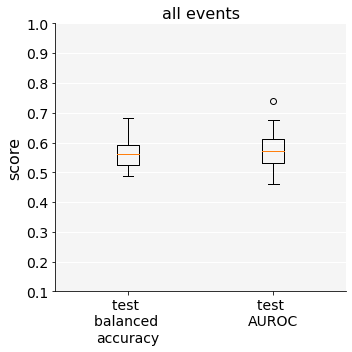

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

scores = []
results = pd.read_csv('out/results/{}_{}_pred_results_combined_events.csv'.format(
            config.classifier_type, config.clf_mode), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
scores.append(results.loc[subject_ids, metrics])
scores = np.array(scores)
fig, axes = putil.create_plot()
axes[0].boxplot(np.transpose(scores[0, :, [0,2]]))
putil.set_ax_visible_spines(axes[0], top=False, right=False)
putil.set_figure_size(fig, 5, 5)
putil.set_ax_title(axes[0], 'all events')
putil.set_ax_axis_labels(axes[0], x_label='', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
putil.set_ax_xticks(axes[0], range(1, 3), [m.replace('roc_auc', 'AUROC').replace('_', ' \n') for m in np.array(metrics)[[0,2]]])
putil.set_ax_yticks(axes[0], yticks, yticks)
plt.tight_layout()
plt.savefig('out/results/{}_{}_scores_events_combined.pdf'.format(config.classifier_type, config.clf_mode))

##### Per scenario

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

SCENARIOS = ['highway', 'rural', 'town']

scores = []
for scenario in SCENARIOS:
    results = pd.read_csv('out/results/{}_{}_pred_results_combined_events_{}.csv'.format(
                config.classifier_type, config.clf_mode, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    scores.append(results.loc[subject_ids, metrics])
scores = np.array(scores)
for i in range(scores.shape[2]):
    fig, axes = putil.create_plot()
    putil.set_ax_visible_spines(axes[0], top=False, right=False)
    putil.set_figure_size(fig, 5, 5)
    axes[0].boxplot(np.transpose(scores[:, :, i]))
    putil.set_ax_title(axes[0], 'all events')
    putil.set_ax_xticks(axes[0], range(1, len(SCENARIOS)+1), SCENARIOS)
    putil.set_ax_yticks(axes[0], yticks, yticks)
    putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label=metrics[i].replace('_', ' ').replace('roc auc', 'AUROC'))
    putil.set_ax_bg_color(axes[0], 'whitesmoke')
    putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
    plt.tight_layout()
    plt.savefig('out/results/{}_{}_scores_events_combined_{}.pdf'.format(config.classifier_type, config.clf_mode, metrics[i]))

#### Per event

##### Overall

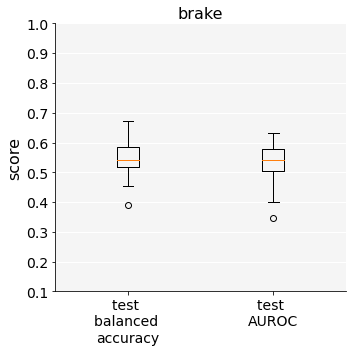

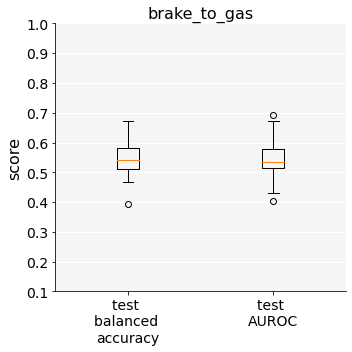

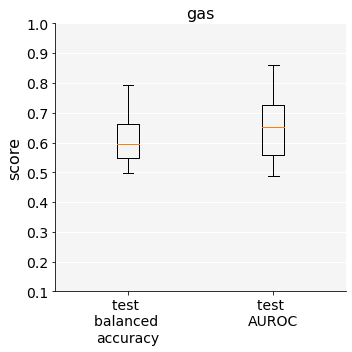

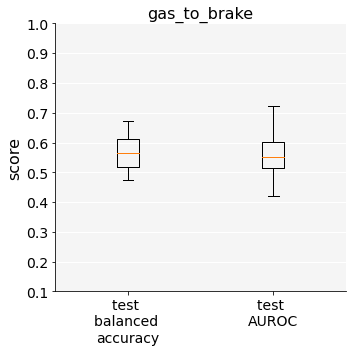

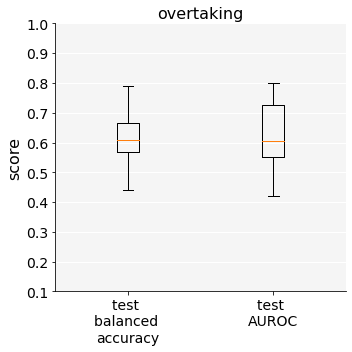

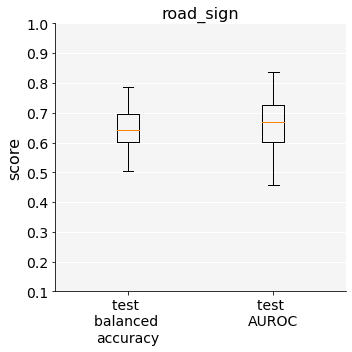

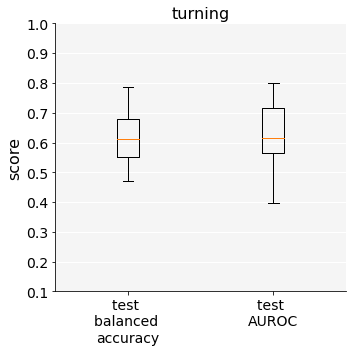

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

for i, event in enumerate(EVENTS):
    scores = []
    results = pd.read_csv('out/results/{}_{}_pred_results_{}.csv'.format(
                config.classifier_type, config.clf_mode, event), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    scores.append(results.loc[subject_ids, metrics])
    scores = np.array(scores)
    fig, axes = putil.create_plot()
    axes[0].boxplot(np.transpose(scores[0, :, [0,2]]))
    putil.set_ax_visible_spines(axes[0], top=False, right=False)
    putil.set_figure_size(fig, 5, 5)
    putil.set_ax_title(axes[0], event)
    putil.set_ax_axis_labels(axes[0], x_label='', y_label='score')
    putil.set_ax_bg_color(axes[0], 'whitesmoke')
    putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
    putil.set_ax_xticks(axes[0], range(1, 3), [m.replace('roc_auc', 'AUROC').replace('_', ' \n') for m in np.array(metrics)[[0,2]]])
    putil.set_ax_yticks(axes[0], yticks, yticks)
    plt.tight_layout()
    plt.savefig('out/results/{}_{}_scores_{}.pdf'.format(config.classifier_type, config.clf_mode, event))

##### Per scenario

/local/home/demircis/DRIVE/mt-sinan-demirci/plotting_util.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(sharex=sharex, sharey=sharey, constrained_layout=constrained_layout)


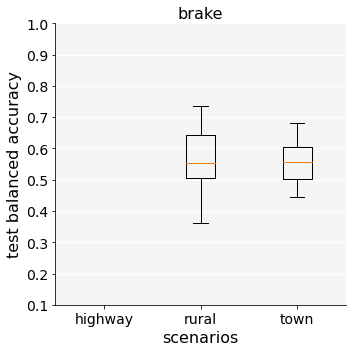

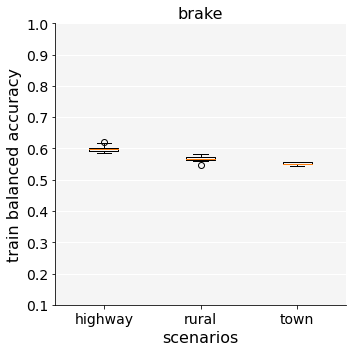

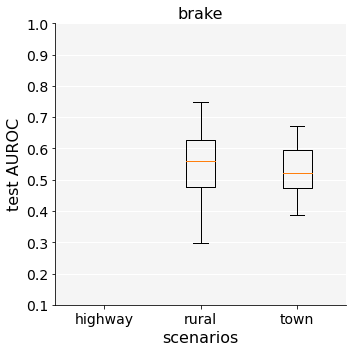

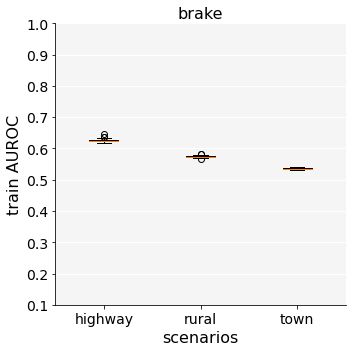

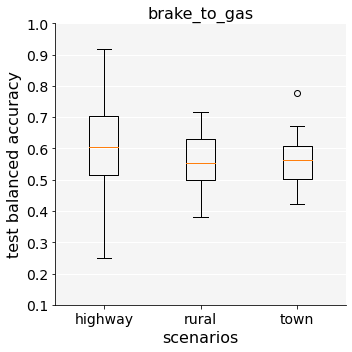

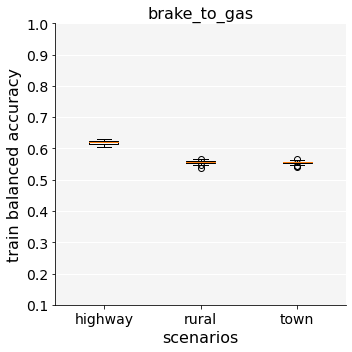

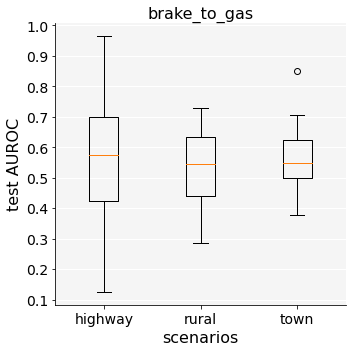

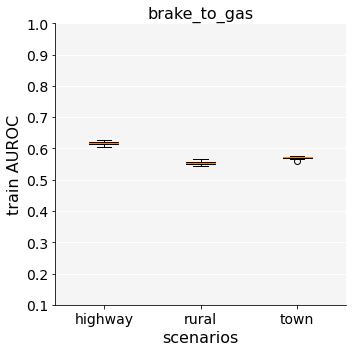

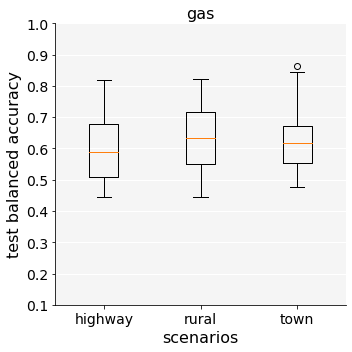

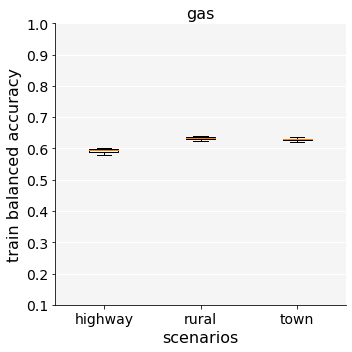

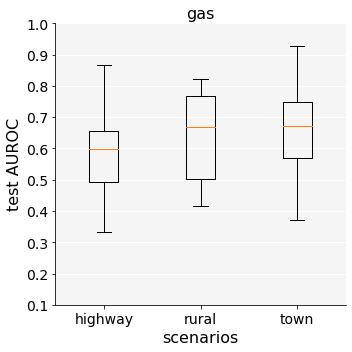

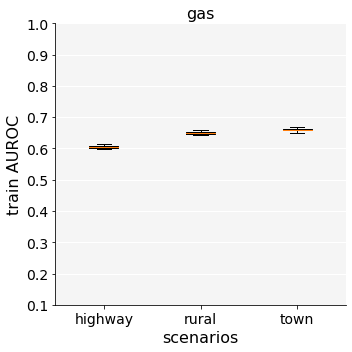

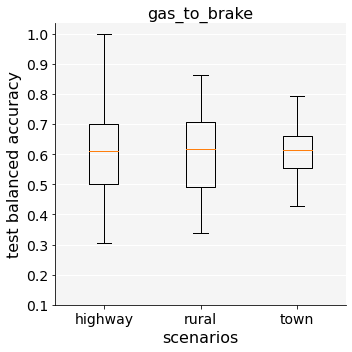

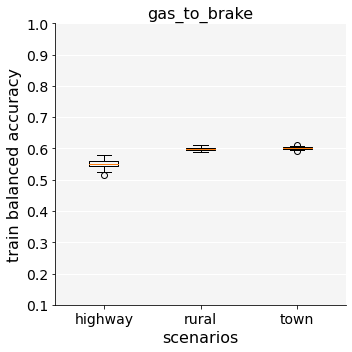

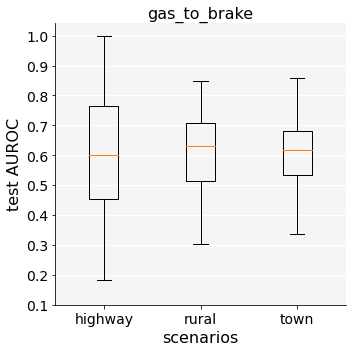

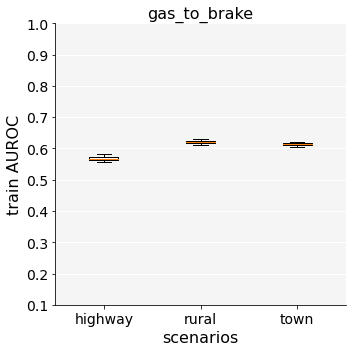

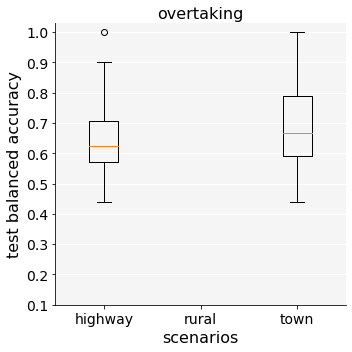

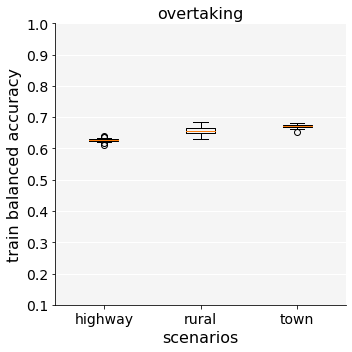

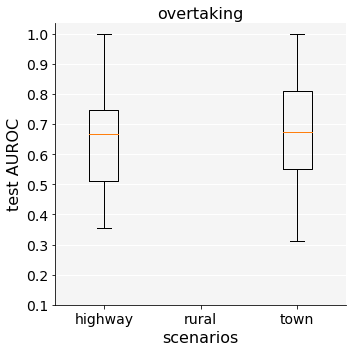

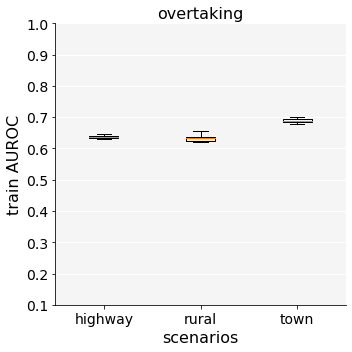

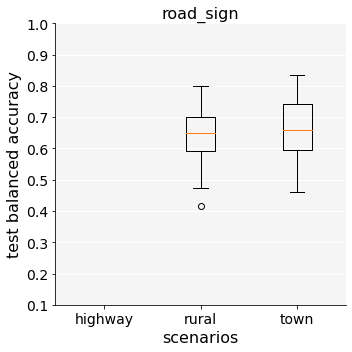

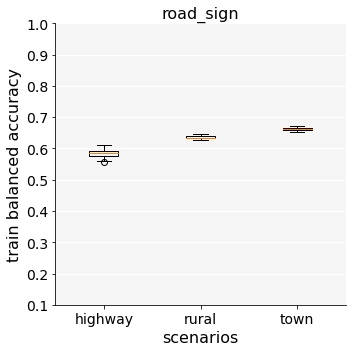

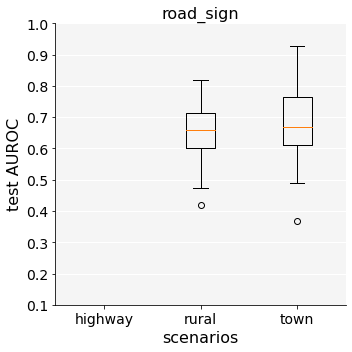

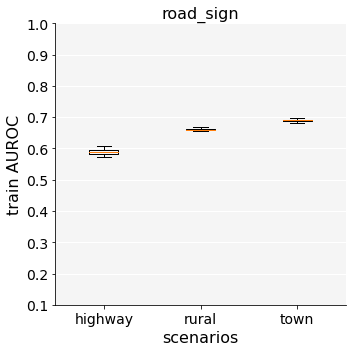

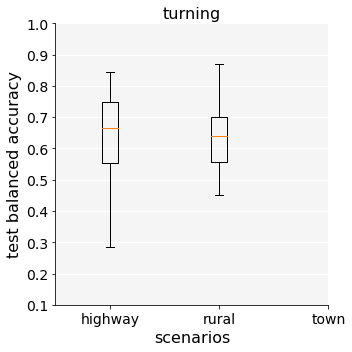

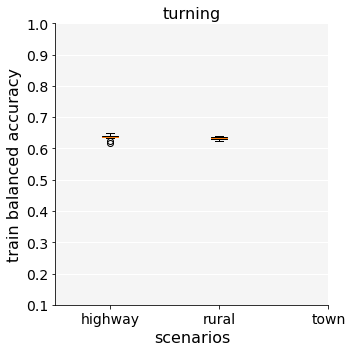

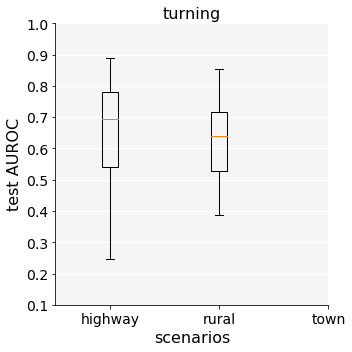

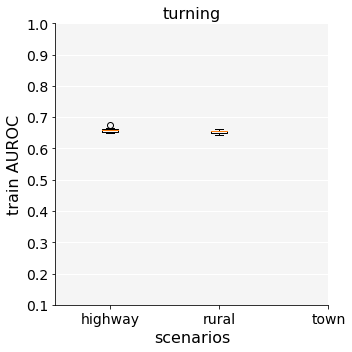

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

SCENARIOS = ['highway', 'rural', 'town']

for i, event in enumerate(EVENTS):
    scores = []
    for scenario in SCENARIOS:
        if event == 'turning' and scenario == 'highway':
            continue
        else:
            results = pd.read_csv('out/results/{}_{}_pred_results_{}_{}.csv'.format(
                        config.classifier_type, config.clf_mode, event, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            scores.append(results.loc[subject_ids, metrics])
    scores = np.array(scores)
    for j in range(scores.shape[2]):
        fig, axes = putil.create_plot()
        putil.set_ax_visible_spines(axes[0], top=False, right=False)
        putil.set_figure_size(fig, 5, 5)
        axes[0].boxplot(np.transpose(scores[:, :, j]))
        putil.set_ax_xticks(axes[0], range(1, len(SCENARIOS)+1), SCENARIOS)
        putil.set_ax_yticks(axes[0], yticks, yticks)
        putil.set_ax_title(axes[0], event)
        putil.set_ax_bg_color(axes[0], 'whitesmoke')
        putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
        putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label=metrics[j].replace('_', ' ').replace('roc auc', 'AUROC'))
        plt.tight_layout()
        plt.savefig('out/results/{}_{}_scores_{}_{}_{}.pdf'.format(config.classifier_type, config.clf_mode, event, scenario, metrics[j]))